## Exercises:
1. E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

2. E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

3. E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

4. E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

5. E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

6. E06: meta-exercise! Think of a fun/interesting exercise and complete it.

## Triagram model 

In [ ]:
import torch

words = open('names.txt', 'r').read().splitlines()

In [76]:
chars = sorted(list(set(''.join(words))))   # A list of characters
stoi = {s:i+1 for i,s in enumerate(chars)}    # Asociate a char with a number
stoi['<S>'] = 0
stoi['<E>'] = 27

itos = {i:s for s,i in stoi.items()}




In [ ]:
# For a trigram we need 27 * 27 * 28 tensor
N = torch.zeros((28,28,28), dtype=torch.int32) #Because our data are integers not floats
N1 = torch.zeros((28), dtype=torch.int32)  # To choose the first element 
for w in words: 
    chs = ['<S>'] + list(w) + ['<E>']     # We need to safe when the words start or end
    for i in range(len(chs)-2):
        if i==0: 
            N1[ix2] +=1
        ix1 = stoi[chs[i]]
        ix2 = stoi[chs[i+1]] 
        ix3 = stoi[chs[i+2]]
        N[ix1,ix2,ix3] +=1


In [ ]:
# For aa the things that come next are:
N[1][1]

tensor([  0,   0,   5,   5,  47,   0,   3,   3,  17,  12,   2,  12,  46,  23,
        174,   0,   0,   3,  83,  28,   8,   0,  14,   0,   0,  20,  11,  40],
       dtype=torch.int32)

In [166]:
N.sum(2,keepdim=True).shape

torch.Size([28, 28, 1])

In [193]:
P = (N + 0.001).float() 
P /= P.sum(2, keepdim=True)
P[1][1].sum()       # The sum of all the probabilities for aa is 1 so its correct

tensor(1.)

In [194]:
P1 = (N1 + 0.001).float() 
P1 /= P1.sum(0, keepdim=True)
P1.sum()

tensor(1.0000)

In [561]:
g = torch.Generator().manual_seed(2147483647)   # For having always the same result 

In [562]:
for _ in range(50): 
    word = ""
    ix1=0
    ix2 = torch.multinomial(P1, num_samples=1, replacement=True, generator=g).item() # We choose the first two letters 
    word += itos[ix2]

    while True: 
        ix3= torch.multinomial(P[ix1][ix2], num_samples=1, replacement=True, generator=g).item() # We choose the first two letters 
        if ix3 == 27: 
            break
        word += itos[ix3]
        ix1 = ix2
        ix2 = ix3
    print(word)


da
ana
hea
jolya
idae
azalisiryn
ardyu
ny
nori
ni
assila
en
ahlanyanden
eddyn
avidaehre
rodihsellyserbis
ah
lanidyn
nettheriseigh
aarioni
elah
illiya
na
luwan
noanderracker
rey
da
eliyashaadenn
lioverra
amir
alkar
ow
emi
handonna
yonna
drithloulina
ya
avynlee
rat
sa
ef
ivona
taky
san
izoelienteey
lanhamerr
nallah
nise
ena
nya


In [197]:
# Now we are going to evaluate how well it works with a loss function 

loglikekihood = 0
for w in words[:2]: 
    chs = ['<S>'] + list(w) + ['<E>']     # We need to safe when the words start or end
    for i in range(len(chs)-2):
        ix1 = stoi[chs[i]]
        ix2 = stoi[chs[i+1]] 
        if i==0: 
            loglikekihood = P1[ix2]
        ix3 = stoi[chs[i+2]]
        loglikekihood = P[ix1,ix2,ix3]
        print (f'{chs[i]} {chs[i+1]} {chs[i+2]} : {loglikekihood:4f}')

<S> e m : 0.188110
e m m : 0.130036
m m a : 0.428506
m a <E> : 0.067181
<S> o l : 0.263943
o l i : 0.111467
l i v : 0.021774
i v i : 0.289936
v i a : 0.161357
i a <E> : 0.369321


In [198]:
loglikekihood = 0
count = 0
for w in words: 
    chs = ['<S>'] + list(w) + ['<E>']     # We need to safe when the words start or end
    for i in range(len(chs)-2):
        ix1 = stoi[chs[i]]
        ix2 = stoi[chs[i+1]] 
        if i==0: 
            loglikekihood += P1[ix2].log()
            count+=1
        ix3 = stoi[chs[i+2]]
        loglikekihood += P[ix1,ix2,ix3].log()
        count += 1

print (loglikekihood)
nll = -loglikekihood
print (-loglikekihood)
print (-loglikekihood/count)



tensor(-528025.9375)
tensor(528025.9375)
tensor(2.3144)


## BETTER SOLUTION!!!!!!!!!!!

In [205]:
# The cleanest solution:
# For a trigram we need 27 * 27 * 28 tensor
N = torch.zeros((28,28,28), dtype=torch.int32) #Because our data are integers not floats
for w in words: 
    chs = ['<S>']+ ['<S>'] + list(w) + ['<E>']     # We need to safe when the words start or end
    for i in range(len(chs)-2):
        ix1 = stoi[chs[i]]
        ix2 = stoi[chs[i+1]] 
        ix3 = stoi[chs[i+2]]
        N[ix1,ix2,ix3] +=1


In [222]:
P = (N+0.001).float() 
P /= P.sum(2, keepdim=True)
P[1][1].sum()       # The sum of all the probabilities for aa is 1 so its correct

tensor(1.)

In [567]:
g = torch.Generator().manual_seed(2147483647)   # For having always the same result 

In [568]:
for _ in range(10): 
    word = ""
    ix1=0
    ix2 = 0
    while True: 
        ix3= torch.multinomial(P[ix1][ix2], num_samples=1, replacement=True, generator=g).item() # We choose the first two letters 
        if ix3 == 27: 
            break
        word += itos[ix3]
        ix1 = ix2
        ix2 = ix3
    print(word)


ca
wil
hea
jolya
idae
azalisiryn
ardyu
brylori
minassila
en


In [225]:
loglikekihood = 0
count = 0
for w in words: 
    chs = ['<S>'] + ['<S>'] + list(w) + ['<E>']     # We need to safe when the words start or end
    for i in range(len(chs)-2):
        ix1 = stoi[chs[i]]
        ix2 = stoi[chs[i+1]] 
        ix3 = stoi[chs[i+2]]
        loglikekihood += P[ix1,ix2,ix3].log()
        count += 1

print (loglikekihood)
nll = -loglikekihood
print (-loglikekihood)
print (-loglikekihood/count)

tensor(-498656.1562)
tensor(498656.1562)
tensor(2.1857)


## Trigram neural network

In [283]:
xs,ys = [], []

for w in words: 
    chs = ['<S>']+ ['<S>'] + list(w) + ['<E>']     # We need to safe when the words start or end
    for i in range(len(chs)-2):
        ix1 = stoi[chs[i]] 
        ix2 = stoi[chs[i+1]] 
        ix3 = stoi[chs[i+2]]
        xs.append((ix1,ix2))
        ys.append(ix3)
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)


In [284]:
xs.shape

torch.Size([228146, 2])

In [285]:
import torch.nn.functional as F
xnew = F.one_hot(xs,num_classes=28).float()
xnew.shape

torch.Size([228146, 2, 28])

In [286]:
# We cannot do a multiplication of tensor that aren't two dimensional. So what we do is combine the last two dimmensions
xnew = xnew.view(-1, 56)
xnew.shape

torch.Size([228146, 56])

In [278]:
# 1. Create a tiny 3D Tensor
# Shape: (2 examples, 2 characters, 3 dimensions)
# Example 1: 'a' (1,0,0) then 'b' (0,1,0)
# Example 2: 'c' (0,0,1) then 'a' (1,0,0)
t = torch.tensor([
    [[1, 0, 0], [0, 1, 0]], 
    [[0, 0, 1], [1, 0, 0]]
])

print("--- ORIGINAL (3D) ---")
print(f"Shape: {t.shape}")
print(t)

# 2. Flatten (Squash)
# We want to merge dim 1 (size 2) and dim 2 (size 3) into size 6.
t_flat = t.view(-1, 6)

print("\n--- FLATTENED (2D) ---")
print(f"Shape: {t_flat.shape}")
print(t_flat)

--- ORIGINAL (3D) ---
Shape: torch.Size([2, 2, 3])
tensor([[[1, 0, 0],
         [0, 1, 0]],

        [[0, 0, 1],
         [1, 0, 0]]])

--- FLATTENED (2D) ---
Shape: torch.Size([2, 6])
tensor([[1, 0, 0, 0, 1, 0],
        [0, 0, 1, 1, 0, 0]])


In [ ]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((56,28), generator=g, requires_grad=True)      # We need more neurons
# Logic
logits = xnew @ W
# softMax
counts = logits.exp()
probs = counts / counts.sum(1,keepdim=True)
num = len(ys)
logits.shape

torch.Size([228146, 28])

In [298]:
## The error of the first one is: 
logProb = 0
count = 0
for i in range (len(ys)): 
    prob = probs[i,ys[i]]
    logProb += prob.log()
    count +=1

print (logProb)
nll = -logProb
print (f'Average: {nll/count}')
# or you can do it like that: 
loss = -probs[torch.arange(len(ys)), ys].log().mean()

tensor(-931705.3750, grad_fn=<AddBackward0>)
Average: 4.083812236785889


In [ ]:
# Forward pass
for _ in range(400):
    logits = xnew @ W
    counts = logits.exp()
    probs = counts / counts.sum(1,keepdim=True)
    loss = -probs[torch.arange(len(ys)), ys].log().mean() +0.0001*(W**2).mean()
    print (loss.item())

    W.grad = None
    loss.backward()

    W.data -= 10*W.grad


2.338656187057495
2.338655471801758
2.3386545181274414
2.338653802871704
2.3386526107788086
2.3386518955230713
2.338650703430176
2.3386502265930176
2.338649272918701
2.3386483192443848
2.3386476039886475
2.33864688873291
2.3386456966400146
2.3386447429656982
2.338644027709961
2.3386433124542236
2.338642120361328
2.338641405105591
2.3386406898498535
2.338639736175537
2.3386390209198
2.3386378288269043
2.338637113571167
2.3386359214782715
2.3386354446411133
2.338634490966797
2.3386335372924805
2.338632583618164
2.3386316299438477
2.3386311531066895
2.338630437850952
2.3386292457580566
2.3386285305023193
2.338627576828003
2.3386268615722656
2.33862566947937
2.3386247158050537
2.3386240005493164
2.338623285293579
2.338622570037842
2.3386216163635254
2.33862042427063
2.3386197090148926
2.3386189937591553
2.338618040084839
2.3386173248291016
2.338616371154785
2.3386154174804688
2.3386144638061523
2.338613748550415
2.3386127948760986
2.3386123180389404
2.338611125946045
2.3386104106903076
2.3

In [ ]:
g = torch.Generator().manual_seed(2147483647)   # For having always the same result 

for _ in range(10): 
    word = ""
    ix1=0
    ix2 = 0
    while True: 
        xs = torch.tensor((ix1,ix2))
        xs = F.one_hot(xs,num_classes=28).float()
        xs = xs.view(-1, 56)
        logits = xs @ W
        counts = logits.exp()
        probs = counts / counts.sum(1,keepdim=True)
        ix3= torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item() # We choose the first two letters 
        if ix3 == 27: 
            break
        word += itos[ix3]
        ix1 = ix2
        ix2 = ix3
    print(word)

ca
way
hea
jowya
iane
azol
miryn
ardyr
byn
kii


2. NEW TRAINING

Im going to improve the model using 729 neurons instead of 56 for the input 

In [612]:
import torch
import random
words = open('names.txt', 'r').read().splitlines()

# 80% Training
# 10% Dev set
# 10% Test set

# 1. Shuffle the dataset randomly
random.seed(42) # Set seed so we get the same split every time
random.shuffle(words)

# 2. Calculate the cut-off points (Indices)
n1 = int(0.8 * len(words))  # The 80% mark
n2 = int(0.9 * len(words))  # The 90% mark (80% + 10%)

print(f"Total words: {len(words)}")
print(f"Split points: {n1}, {n2}")

# 3. Slice the list
Xtr = words[:n1]      # 0% to 80%
Xdev = words[n1:n2]   # 80% to 90%
Xte = words[n2:]      # 90% to 100%

print(f"Train size: {len(Xtr)}")
print(f"Dev size:   {len(Xdev)}")
print(f"Test size:  {len(Xte)}")


Total words: 32033
Split points: 25626, 28829
Train size: 25626
Dev size:   3203
Test size:  3204


In [613]:
def Define_Triagram_DataSet_NN(xset):
    xs = [] 
    ys = []
    for w in xset: 
        chs = ['<S>']+ ['<S>'] + list(w) + ['<E>']     # We need to safe when the words start or end
        for i in range(len(chs)-2):
            ix1 = stoi[chs[i]] 
            ix2 = stoi[chs[i+1]] 
            ix3 = stoi[chs[i+2]]
            xs.append((ix1,ix2))
            ys.append(ix3)
            
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs, ys


In [702]:
import torch.nn.functional as F



def train_this(xTrain, yTrain, normalization, learning_rate):

    xTrain = xTrain[:, 0]+ 28 * xTrain[:,1]

    g = torch.Generator().manual_seed(2147483647)
    W = torch.randn((784,28), generator=g, requires_grad=True)      # We need more neurons

    # Forward pass
    for _ in range(150):
        logits = W[xTrain]
        counts = logits.exp()
        probs = counts / counts.sum(1,keepdim=True)
        loss = -probs[torch.arange(len(yTrain)), yTrain].log().mean() +normalization*(W**2).mean()

        W.grad = None
        loss.backward()

        W.data -= learning_rate*W.grad
    print (f'Training Loss: {loss.item()} with {learning_rate=} and {normalization=}')

    return W




In [700]:
def try_set(xD,yD, W):

    xD = xD[:, 0]+ 28 * xD[:,1]
    xnew = F.one_hot(xD,num_classes=784).float()

    logits = xnew @ W
    counts = logits.exp()
    probs = counts / counts.sum(1,keepdim=True)
    loss = -probs[torch.arange(len(yD)), yD].log().mean() +0.001*(W**2).mean()
    print (f'Loss :{loss.item()}')
    return loss.item()



In [701]:
xTrain,yTrain =  Define_Triagram_DataSet_NN(Xtr)
Wnew = train_this(xTrain, yTrain, 0.0001,10)

xDev,yDev = Define_Triagram_DataSet_NN(Xdev)
try_set(xDev,yDev, Wnew)

xTest,yTest = Define_Triagram_DataSet_NN(Xte)
try_set(xTest,yTest, Wnew)


torch.Size([182625, 784])
Training Loss: 2.8551440238952637 with learning_rate=10 and normalization=0.0001
Loss :2.840275764465332
Loss :2.855293035507202


2.855293035507202

TUNING THE HYPERVALUES

In [703]:
## Tuning the hy0erValues (the learning rate)
xTrain,yTrain =  Define_Triagram_DataSet_NN(Xtr)
xDev,yDev = Define_Triagram_DataSet_NN(Xdev)

results= []
W_trained = []
for i in range (10):
    print('------')
    learning_rate = 0.01*(3**i)
    print (f'Learning rate: {learning_rate}')
    newW = train_this(xTrain, yTrain, 0, learning_rate)
    W_trained.append(newW)
    results.append((try_set(xDev,yDev, newW), learning_rate))
    


------
Learning rate: 0.01
Training Loss: 3.8864946365356445 with learning_rate=0.01 and normalization=0
Loss :3.874152183532715
------
Learning rate: 0.03
Training Loss: 3.875385046005249 with learning_rate=0.03 and normalization=0
Loss :3.8629696369171143
------
Learning rate: 0.09
Training Loss: 3.844369649887085 with learning_rate=0.09 and normalization=0
Loss :3.8317790031433105
------
Learning rate: 0.27
Training Loss: 3.76668643951416 with learning_rate=0.27 and normalization=0
Loss :3.7538046836853027
------
Learning rate: 0.81
Training Loss: 3.608762502670288 with learning_rate=0.81 and normalization=0
Loss :3.5955722332000732
------
Learning rate: 2.43
Training Loss: 3.345388174057007 with learning_rate=2.43 and normalization=0
Loss :3.331122636795044
------
Learning rate: 7.29
Training Loss: 2.966764450073242 with learning_rate=7.29 and normalization=0
Loss :2.9515371322631836
------
Learning rate: 21.87
Training Loss: 2.617121696472168 with learning_rate=21.87 and normaliza


--- FINAL RESULTS (Sorted by Best Loss) ---
LR:   196.8300 | Loss: 2.3562
LR:    65.6100 | Loss: 2.3896
LR:    21.8700 | Loss: 2.6070
LR:     7.2900 | Loss: 2.9515
LR:     2.4300 | Loss: 3.3311
LR:     0.8100 | Loss: 3.5956
LR:     0.2700 | Loss: 3.7538
LR:     0.0900 | Loss: 3.8318
LR:     0.0300 | Loss: 3.8630
LR:     0.0100 | Loss: 3.8742


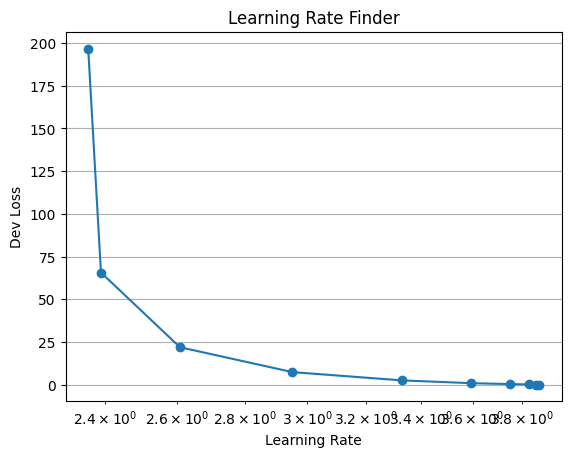

In [704]:
import matplotlib.pyplot as plt
print("\n--- FINAL RESULTS (Sorted by Best Loss) ---")
# Sort by the 2nd item (Loss)
results.sort( key=lambda x: x[0]) 

for loss, lr in results:
    print(f"LR: {lr:10.4f} | Loss: {loss:.4f}")

# 2. Plot the Curve (The "U" Shape)
# We separate the data back into two lists for plotting
losses, lrs = zip(*results)

# Filter out NaNs for plotting
clean_lrs = [l for l, loss in results if not torch.isnan(torch.tensor(loss))]
clean_losses = [loss for l, loss in results if not torch.isnan(torch.tensor(loss))]

plt.plot(clean_lrs, clean_losses, marker='o')
plt.xscale('log') # CRITICAL: Use Log scale because LRs vary wildly
plt.xlabel('Learning Rate')
plt.ylabel('Dev Loss')
plt.title('Learning Rate Finder')
plt.grid(True)
plt.show()

------
Learning rate: 50
Training Loss: 2.4331421852111816 with learning_rate=50 and normalization=0
Loss :2.431868076324463
------
Learning rate: 70
Training Loss: 2.3784501552581787 with learning_rate=70 and normalization=0
Loss :2.380568504333496
------
Learning rate: 90
Training Loss: 2.3444058895111084 with learning_rate=90 and normalization=0
Loss :2.3489534854888916
------
Learning rate: 110
Training Loss: 2.3209545612335205 with learning_rate=110 and normalization=0
Loss :2.3274545669555664
------
Learning rate: 130
Training Loss: 2.3076541423797607 with learning_rate=130 and normalization=0
Loss :2.3199920654296875
------
Learning rate: 150
Training Loss: 2.2940468788146973 with learning_rate=150 and normalization=0
Loss :2.3075201511383057
------
Learning rate: 170
Training Loss: 2.2821197509765625 with learning_rate=170 and normalization=0
Loss :2.2951953411102295
------
Learning rate: 190
Training Loss: 2.2927136421203613 with learning_rate=190 and normalization=0
Loss :2.3

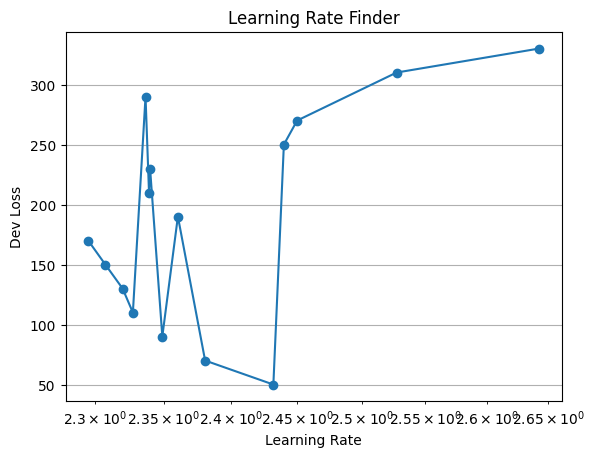

In [707]:
## Tuning the hy0erValues (the learning rate)
xTrain,yTrain =  Define_Triagram_DataSet_NN(Xtr)
xDev,yDev = Define_Triagram_DataSet_NN(Xdev)

results_2= []
W_trained2 = []
for i in range (15):
    print('------')
    learning_rate = (50 +20*i)
    print (f'Learning rate: {learning_rate}')
    newW = train_this(xTrain, yTrain, 0, learning_rate)
    W_trained2.append(newW)
    results_2.append((try_set(xDev,yDev, newW), learning_rate))

print("\n--- FINAL RESULTS (Sorted by Best Loss) ---")
# Sort by the 2nd item (Loss)
results_2.sort( key=lambda x: x[0]) 

for loss, lr in results_2:
    print(f"LR: {lr:10.4f} | Loss: {loss:.4f}")

# 2. Plot the Curve (The "U" Shape)
# We separate the data back into two lists for plotting
losses, lrs = zip(*results_2)

# Filter out NaNs for plotting
clean_lrs = [l for l, loss in results_2 if not torch.isnan(torch.tensor(loss))]
clean_losses = [loss for l, loss in results_2 if not torch.isnan(torch.tensor(loss))]

plt.plot(clean_lrs, clean_losses, marker='o')
plt.xscale('log') # CRITICAL: Use Log scale because LRs vary wildly
plt.xlabel('Learning Rate')
plt.ylabel('Dev Loss')
plt.title('Learning Rate Finder')
plt.grid(True)
plt.show()


In [709]:
## Normalization with the best learning rate
## Tuning the hy0erValues (the learning rate)

xTrain,yTrain =  Define_Triagram_DataSet_NN(Xtr)
xDev,yDev = Define_Triagram_DataSet_NN(Xdev)

results_N= []
W_trainedN = []
for i in range (15):
    print('------')
    learning_rate = 170
    normalization_rate = 0.000000001*(8**i)
    print (f'Normalization rate: {normalization_rate}')
    newW = train_this(xTrain, yTrain, normalization_rate, learning_rate)
    W_trainedN.append(newW)
    results_N.append((try_set(xDev,yDev, newW), normalization_rate))

print("\n--- FINAL RESULTS (Sorted by Best Loss) ---")
# Sort by the 2nd item (Loss)
results_N.sort( key=lambda x: x[0]) 

for loss, lr in results_N:
    print(f"NRate: {lr:10.4f} | Loss: {loss:.4f}")


------
Normalization rate: 1e-09
Training Loss: 2.288764715194702 with learning_rate=170 and normalization=1e-09
Loss :2.3189573287963867
------
Normalization rate: 8e-09
Training Loss: 2.2959682941436768 with learning_rate=170 and normalization=8e-09
Loss :2.3057072162628174
------
Normalization rate: 6.4e-08
Training Loss: 2.2806143760681152 with learning_rate=170 and normalization=6.4e-08
Loss :2.2923078536987305
------
Normalization rate: 5.12e-07
Training Loss: 2.2939717769622803 with learning_rate=170 and normalization=5.12e-07
Loss :2.340221881866455
------
Normalization rate: 4.096e-06
Training Loss: 2.281137228012085 with learning_rate=170 and normalization=4.096e-06
Loss :2.291957378387451
------
Normalization rate: 3.2768e-05
Training Loss: 2.28499698638916 with learning_rate=170 and normalization=3.2768e-05
Loss :2.306122303009033
------
Normalization rate: 0.000262144
Training Loss: 2.287832260131836 with learning_rate=170 and normalization=0.000262144
Loss :2.305272817611

4. E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?


First im going to improve the model 

In [ ]:
hithi

torch.Size([182625, 784])
Training Loss: 2.199857473373413 with learning_rate=170 and normalization_rate=4.096e-06


In [720]:
g = torch.Generator().manual_seed(2147483647)   # For having always the same result 

for _ in range(10): 
    word = ""
    ix1=0
    ix2 = 0
    while True: 
    
        logits = W[ix1+28*ix2]
        counts = logits.exp()
        probs = counts / counts.sum(0,keepdim=True)
        ix3= torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item() # We choose the first two letters 
        if ix3 == 27: 
            break
        word += itos[ix3]
        ix1 = ix2
        ix2 = ix3
    print(word)

da
wil
hea
jolya
idae
jornesiryn
hadys
brylori
minassila
en


F_cross Entropy

In [ ]:
# F.cross_entropy combines Softmax + Negative Log Likelihood in one efficient step.
# CRITICAL: It expects raw 'logits', NOT probabilities. It handles numerical stability internally.

# --- LOSS CALCULATION ---
# We replace the manual Softmax -> Log -> NLL steps with F.cross_entropy.
# Why?
# 1. Efficiency: It fuses operations to run faster.
# 2. Stability: It uses the "Log-Sum-Exp" trick to prevent 'NaN' errors 
#    if logits are very large (avoids exploding exponentials).
# Note: Always pass raw 'logits' into this, never 'probs'.

# This is the same = 

logits = W[xTrain]      # We can ommit the matrix multiplication just doing this 

counts = logits.exp()
probs = counts / counts.sum(1,keepdim=True)
loss = -probs[torch.arange(len(yTrain)), yTrain].log().mean() +normalization_rate*(W**2).mean()
# === 
loss = F.cross_entropy(logits, yTrain) + normalization_rate * (W**2).mean()

ValueError: For 1D input, 1D target must have size 1, but got target size: 182625